## Utilisation du jeu de données Xview2, qui intitialement présebnte des exemples de territoire avant et après dommage

Je m'écarte ici un peu de l'idée initiale qui était de produire un dataset à l'aide du RIl et de la BDTOPO et je me concentre + sur les datasets labellisés préexistants. J'entraine un modèle de segmentation de suus ou un modèle de déttection d'objet et je vois comment ça réagit sur donnée spleiades. 
Dans tousd les cas le travail sur le RIL et la BD TOPO est à conserver puisque ces derniers servent de vzlidation !

In [2]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install -q -q -q tqdm # progresbar

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.3 MB/s eta 0:00:00:00:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 19.2 MB/s eta 0:00:00a 0:00:01


In [2]:
from zipfile import ZipFile
import s3fs
import tarfile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import DataLoader,  random_split
from torch.utils.data.dataset import Dataset
import torch.nn as nn
from tqdm import tqdm

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},key ='XMB3NPLOZDVX0WNE6153', secret = 'sjv23FK1803B0cjV0f4gqj6bFgS80wJvk8Ntv7bm', token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJYTUIzTlBMT1pEVlgwV05FNjE1MyIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc1MjQ5OTY4LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImNsZW1lbnQuZ3VpbGxvQGluc2VlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTY3NTUxNDEyMiwiZmFtaWx5X25hbWUiOiJHdWlsbG8iLCJnaXZlbl9uYW1lIjoiQ2zDqW1lbnQiLCJncm91cHMiOlsiY2hhbGxlbmdlZGF0YS1lbnMiLCJmdW5hdGhvbiIsInNsdW1zLWRldGVjdGlvbiJdLCJpYXQiOjE2NzUyNDk5NzAsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiJjNTJlODhhMS0zNTEyLTQzMTAtYWViYy1kMzAxOTEyZGY3NDAiLCJsb2NhbGUiOiJlbiIsIm5hbWUiOiJDbMOpbWVudCBHdWlsbG8iLCJub25jZSI6ImZiZjJmNTI3LTIxOTYtNGYwNi04NTUzLWMxMzg2NDJiYzE5ZiIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJjZ3VpbGxvIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNlc3Npb25fc3RhdGUiOiI0NDIwMTFhMC02MDk5LTRkOTYtYjIxMy04ZTFiMGFmM2I0MmYiLCJzaWQiOiI0NDIwMTFhMC02MDk5LTRkOTYtYjIxMy04ZTFiMGFmM2I0MmYiLCJzdWIiOiIzYjA2ZWZhNC01OWZlLTQzYzgtYTAyYi1hOTRkOWI0YjU0NGUiLCJ0eXAiOiJCZWFyZXIifQ.UhQ2IGMyFrPOY9edbScANkJd0C3zLpS3E3sKNXoIZQYvFGkLEyyLkT6jNRt04rwyYtK9HgXijkTzEOR4u-gOWA')

In [5]:
# je travaille sur une version minimale du dataset xview, le vrai fait 50 giga.. mais ça devrait déjà faire l'affaire pour travailler
fs.get('projet-slums-detection/Donnees/data_xBD.tar', 'data_xBD.tar')

In [6]:
tar = tarfile.open("data_xBD.tar", "r:gz")
tar.extractall()
tar.close()

### chargement/observation en place des données

In [3]:
liste_image  = sorted(os.listdir("train/images/"))
liste_label  = sorted(os.listdir("train/labels/")) # boundingbox et polygones !!
liste_target  = sorted(os.listdir("train/targets/")) # le masque de segmentation !!

In [4]:
selec_pre_disaster = [nom_image.split("_")[2] == "pre" for nom_image in liste_image]
liste_image = np.array(liste_image)[selec_pre_disaster]
liste_label = np.array(liste_label)[selec_pre_disaster]
liste_target = np.array(liste_target)[selec_pre_disaster]

print(np.sum(selec_pre_disaster)) # 3000 images pour s'entrainer avec des exemples entourés

train_images_paths = ["train/images/" + elt for elt in liste_image]
train_masks_paths = ["train/targets/" + elt for elt in liste_target]


2799


## Observation du dataset

- Images de dimension 1024-1024 à découper en 4 * 250 pour avoir un diviseur de 2000 (pour les données pleiades) (donc en 4)
- Dans la classe data set splitter l'image en 4 et prendre un bout aléatoirement à chaque fois
- image à 3 channels, pas de RGB ici..
- est ce vraiment la mêlme résolution que pleiade ? résistance à la résolution ?

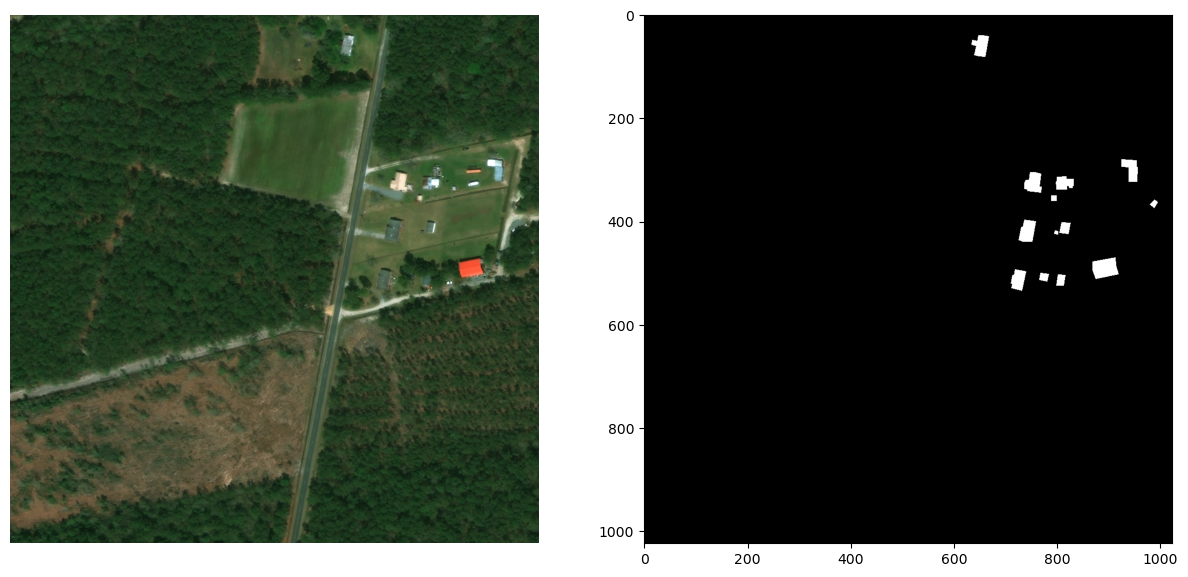

In [5]:
img = Image.open(train_images_paths[30]) # 30 ok
img = img.resize((1000,1000))

masque = Image.open(train_masks_paths[30])
masque = np.array(masque)
show_mask = np.empty((*masque.shape, 3))
show_mask[masque == 1, :] = [255,255,255]
show_mask = show_mask.astype(np.uint8)

# On traçe
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (15,15))
ax1.imshow(img)
ax1.axis("off")
ax2.imshow(show_mask)
plt.show()

A mettre dans la classe dataset ! sélection d'un pa(tch aléatoire parmi les 16  possibles

1 0


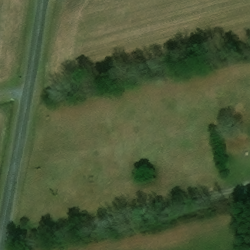

In [8]:
img = Image.open(train_images_paths[35])

img = img.crop((0,0,1000,1000))# je dégomme les derniers pixels..
img

facteur_div = 250
width, height = img.size

num_subparts_x = width//facteur_div
num_subparts_y =  height//facteur_div

# sélection aléatoire d'une aprtie de l'image pour le dataset
i = np.random.randint(num_subparts_x)
j = np.random.randint(num_subparts_y)

print(i,j)

left = j * facteur_div
right = (j+1) * facteur_div
top = i * facteur_div
bottom =(i+1)*facteur_div

out = img.crop((left,top,right,bottom))
out

Polygones associés au bati

In [6]:
 class CustomDataset(Dataset):
    def __init__(self, image_paths,mask_paths, facteur_div = 250):   # initial logic happens like transform
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.facteur_div = 250
        
    def __getitem__(self, idx):
       
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        with Image.open(self.image_paths[idx]) as img :
            
            width, height = img.size

            num_subparts_x = width//self.facteur_div
            num_subparts_y =  height//self.facteur_div
            # sélection aléatoire d'une aprtie de l'image pour le dataset
            i = np.random.randint(num_subparts_x)
            j = np.random.randint(num_subparts_y)

            left = j * self.facteur_div
            right = (j+1) * self.facteur_div
            top = i * self.facteur_div
            bottom =(i+1)*self.facteur_div

            img = img.crop((left,top,right,bottom))
            img = img.convert("RGB")
            img_pil = img
            
        with Image.open(self.mask_paths[idx]) as masque :
            masque = masque.crop((left,top,right,bottom))
            masque = np.array(masque)
         
        
        masque = torch.tensor(masque,dtype = torch.long)
        img = torch.tensor(np.array(img,dtype = float), dtype =torch.float).permute(2,0,1)
        
        ID = str(self.image_paths[idx])
     
        return {"image": img, "masque" : masque,"image_pillow": np.array(img_pil) , "id" : ID} 
        
    def __len__(self):  
        return len(self.mask_paths)

In [7]:
all_dataset = CustomDataset(train_images_paths,train_masks_paths)
one_element = next(iter(all_dataset))

one_element["image"].shape
#torch.max(one_element["masque"])


torch.Size([3, 250, 250])

In [8]:
config = {"batch_size" : 17,
          "freq monitoring" : 10}

In [9]:
all_loader = DataLoader(all_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=0)

train_size = 2000
val_size = len(all_dataset.mask_paths) - train_size
#dans la liste donner la taille du train et la taille deu test
train_dataset, valid_dataset = random_split(all_dataset,[train_size,val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], 
                          shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=3, shuffle=True, num_workers=0)

next(iter(valid_loader))["image"].shape # parfait

torch.Size([3, 3, 250, 250])

In [92]:
if torch.cuda.is_available() : device= torch.device("cuda:0" )
else : device = "cpu"

print("Using {} device".format(device))
if torch.cuda.is_available() :
    print("nom du GPU :", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

    # Load the pretrained model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False) # 233 Mega
# 1 classe !
model.classifier[4] = nn.Conv2d(256,2,kernel_size = (1,1),stride =(1,1))

model = model.to(device)


Using cuda:0 device
nom du GPU : Tesla T4
GPU initialisé :  True


/opt/mamba/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/onyxia/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [93]:

# Initialize the number of parameters
total_params = 0

# Loop through the parameters in the model
for param in model.parameters():
    # Get the size of the parameter tensor
    size = param.size()
    # Multiply the size of the tensor by the number of elements in it
    num_params = torch.prod(torch.tensor(size)).item()
    # Add the number of parameters to the total
    total_params += num_params

# Print the total number of parameters
print("Total number of parameters: ", total_params) # 60 millions..


Total number of parameters:  58626114


In [ ]:
# autre idée : pour un batch donné 
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(100):
    
    running_loss = 0.0
    t= tqdm(train_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
    epoch_loop = enumerate(t)

    for i, data in epoch_loop:
        
        images = data["image"].to(device)
        labels = data["masque"].to(device)
        optimizer.zero_grad()
        output = model(images)["out"]
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        del images, labels, output
        running_loss += loss.item()
        
        if (i+1) % config['freq monitoring'] == 0:  
                t.set_description("epoch %i, 'mean loss: %.6f'" % (epoch+1,running_loss/config['freq monitoring']))
                t.refresh()
                running_loss =0
    
#Save the trained model
#torch.save(model.state_dict(), 'path/to/model.pth')



epoch 1:   8%|▊         | 9/118 [00:21<04:24,  2.42s/it]

Wandb

- Contacter Raya / dinamis
- apurement du jeu de données , trop de patch sans logements.. à enlever et c'est faisable (en filtrant au préalable sur les labels)
- 5 min par epoch => 8h pour 100 epochs
- la loss sembledimiué
- je n'ai pas réadapté la sortie du modèle ici je suis resté en 22 classes.. mais bizarrement ça marche il vamettree 0 sur toutes les autres..
- Faire du wand b !!
- évaluer le modèle sur macouria !!
- inscription données pleiades pour el compte de la dmrg
- tenter batch 20 et brancher avec le framework image des gars c'est la limite après ç!a crash
- dessiner au brouillon l'architecture du projet avec les entrainemenbt avec la volonté detre agnostique au type de modèle
- validation en utilisant les labels RIL !!
- transferabilité résolution / couluers
- faire un taf en 2 temps test buildoing dans la zone puis segmentation
- to do : utiliser les bounding box pour faire autre chose que de la segmentation
- faire un énorme schéma
- équilibrer jeu de donnée avec les 0 et 1. prendre que des exemple ou il y a des 1

## Tests visuels du modele

In [52]:
np.max(output_predictions)

1

array([[[ 4.66971342e-310,  4.66982342e-310,  4.66971342e-310],
        [ 4.66982342e-310,  3.78059769e+001,  4.78927689e+001],
        [ 5.35691300e+001,  5.87038651e+001,  6.38386002e+001],
        ...,
        [ 5.83122635e+001,  5.19854508e+001,  4.56586380e+001],
        [ 3.60312577e+001,  2.81441384e+001,  2.22726174e+001],
        [ 1.64010658e+001,  1.53290043e+001,  1.53290043e+001]],

       [[ 2.35891914e+001,  2.35891914e+001,  2.89475289e+001],
        [ 3.93433609e+001,  5.27917252e+001,  6.84801789e+001],
        [ 8.15364533e+001,  9.28930817e+001,  1.04249710e+002],
        ...,
        [ 5.90478897e+001,  5.19668351e+001,  4.48857804e+001],
        [ 3.21583634e+001,  2.39059029e+001,  1.58662663e+001],
        [ 1.17795811e+001,  1.05663776e+001,  1.05663776e+001]],

       [[ 3.48614579e+001,  3.48614579e+001,  5.05330582e+001],
        [ 7.63986970e+001,  1.15731278e+002,  1.82127838e+002],
        [ 2.10537628e+002,  2.32775665e+002,  2.55013825e+002],
        ..

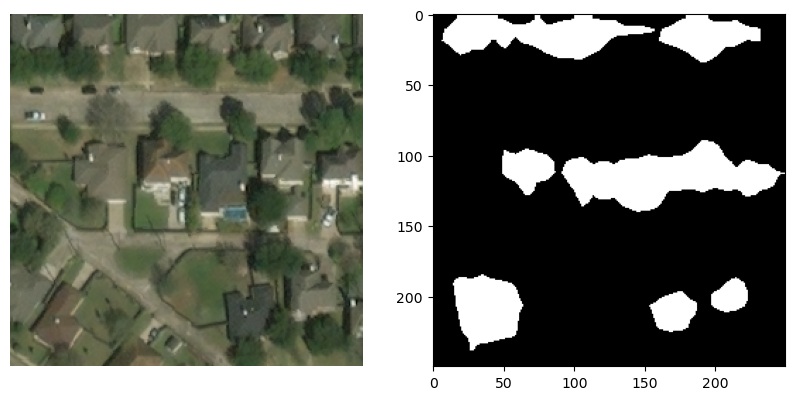

In [100]:
# 250*250 = 62500
indice_dans_batch = 0
data_val  = next(iter(valid_loader))
data_val["image"].shape
output = np.array(model(data_val["image"].to(device))["out"].to("cpu").detach())[indice_dans_batch]
output_predictions = output.argmax(0)
img_init = Image.fromarray(np.array(data_val["image_pillow"][indice_dans_batch]))

masque = output_predictions
show_mask = np.zeros((*masque.shape, 3))
show_mask[masque == 1, :] = [255,255,255]
show_mask = show_mask.astype(np.uint8)

fig,(ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
ax1.imshow(img_init)
ax1.axis("off")
ax2.imshow(show_mask)
plt.show()

In [ ]:
# pleiade !!!!! test 

### Les contours géométriques en Json si besoin !! bounding box etc..

In [ ]:
import json
f = open(label_path)
dico = jason.load(f)
  
# Closing file
f.close()

In [21]:
dico.keys()
dico["metadata"]

{'sensor': 'GEOEYE01',
 'provider_asset_type': 'GEOEYE01',
 'gsd': 1.958603,
 'capture_date': '2018-04-06T15:49:36.000Z',
 'off_nadir_angle': 24.974987,
 'pan_resolution': 0.4894778,
 'sun_azimuth': 140.36385,
 'sun_elevation': 55.891373,
 'target_azimuth': 282.33646,
 'disaster': 'hurricane-florence',
 'disaster_type': 'flooding',
 'catalog_id': '105001000F48CD00',
 'original_width': 1024,
 'original_height': 1024,
 'width': 1024,
 'height': 1024,
 'id': 'MjM1NDMxMg.nXO3IBd7BnYBtW8COFwnVkMrXUQ',
 'img_name': 'hurricane-florence_00000024_pre_disaster.png'}